In [9]:
from parse import *
from PIL import Image, ImageDraw
from sklearn.neighbors import NearestNeighbors 
from dataloader import SimpleImageFolder
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from pathlib import Path
import os
import torch
import numpy as np

In [2]:
products_list = get_data(json_path = '../data/shoes.json')


sketch_path = '../data/sketches/COCO_val2014_000000163852.jpg'
sketch = Image.open(sketch_path)
caption = 'It is a plate of food.'


image_list = []
for item in os.listdir('../data/images'):
    if '.ipynb' not in str(item):
        image_list.append(str(item))

In [3]:
dataset = SimpleImageFolder(image_list)
dataloader = DataLoader(
    dataset,
    batch_size=32,
    # collate_fn=collate_fn,
    shuffle=False,
    num_workers=1,
    pin_memory=True,
    sampler=None,
    drop_last=False,
)

In [4]:
all_image_path = []
all_image_features = []
batch_num = 0
image_folder = Path.cwd().parent / 'data' / 'images'

with torch.no_grad():
    for batch in dataloader:
        print(f'Batch: {batch_num}')
        image_paths = batch

        for idx, image_name in enumerate(image_paths):
            print(f'Done image {idx}')
            cur_path = image_folder / image_name
            emb = get_image_embedding(image_folder / image_name)
            all_image_features.append(emb)
            all_image_path.append(image_folder / image_name)

        batch_num += 1
        print(' -- Done\n')
        


query_feat = get_fused_embedding(sketch_path, caption)
feats = all_image_features
nbrs = NearestNeighbors(n_neighbors=10, algorithm='brute', metric='cosine').fit(feats)

Batch: 0
Done image 0
Processing: /home/tcm/hcmus/cs419/freaky-retrieval/server/data/images/COCO_val2014_000000407298.jpg
is path: True
status code: 200
result: {'embedding': [[0.07603798061609268, -0.041402529925107956, -0.0426211953163147, 0.03148116543889046, -0.0022611990571022034, 0.028870387002825737, -0.007020535413175821, 0.06300842761993408, 0.06545361131429672, -0.012291074730455875, 0.04247152805328369, -0.03720192611217499, 0.011558386497199535, -0.03561265766620636, 0.04736829549074173, -0.013537098653614521, 0.03770071640610695, 0.0031102881766855717, -0.06017603352665901, -0.032980553805828094, 0.04910885542631149, -0.037299882620573044, -0.06107921525835991, -0.009590418078005314, 0.008897754363715649, -0.03852585330605507, 0.028512340039014816, 0.06099497899413109, 0.008249121718108654, -0.04606473073363304, -0.01877385564148426, 0.02077910117805004, -0.019348077476024628, 0.020070062950253487, -6.613974983338267e-05, 0.022387932986021042, -0.04848824441432953, -0.0748

In [10]:
# list to numpy
query_feat = np.array(query_feat).reshape(1, -1)

In [25]:
def mark_boundary(img, color=(0,255,0)):
    draw = ImageDraw.Draw(img)
    draw.rectangle([5, 5, img.width-5, img.height-5], fill=None, outline=color, width=10)
    return img

def get_image_list(query_feat):

    distances, indices = nbrs.kneighbors(query_feat)

    im_list = []
    for ind in indices[0]:
        file_loc = str(all_image_path[ind])
        img = Image.open(file_loc)
        try:
            #if using images from COCO benchmark and sketch from our dataset, we can check id and mark the correct one with green border
            imid = int(sketch_path.split('/')[-1].split('_')[2][:-4])
            cur_imid = int(file_loc.split('/')[-1].split('_')[2].split('.')[0])
            if cur_imid == imid:
                img = mark_boundary(img)
        except:
            print('except')
            img = Image.open(file_loc)
        im_list.append(img)
    return im_list

im_list = [sketch] + get_image_list(query_feat)

In [26]:
def get_concat_hn(ims):
    sum_w = 0
    for im in ims:
        #im = im.resize((256,256))
        sum_w += 256#im.width

    max_h = 256#max([im.height for im in ims])

    dst = Image.new('RGB', (sum_w ,max_h))
    cur_x = 0
    for im in ims:
        dst.paste(im.resize((256,256)), (cur_x, 0))
        cur_x += 256#im.width
    #dst.paste(im2, (im1.width, 0))
    #dst.paste(im3, (im1.width+im2.width, 0))
    return dst

Caption: It is a plate of food.


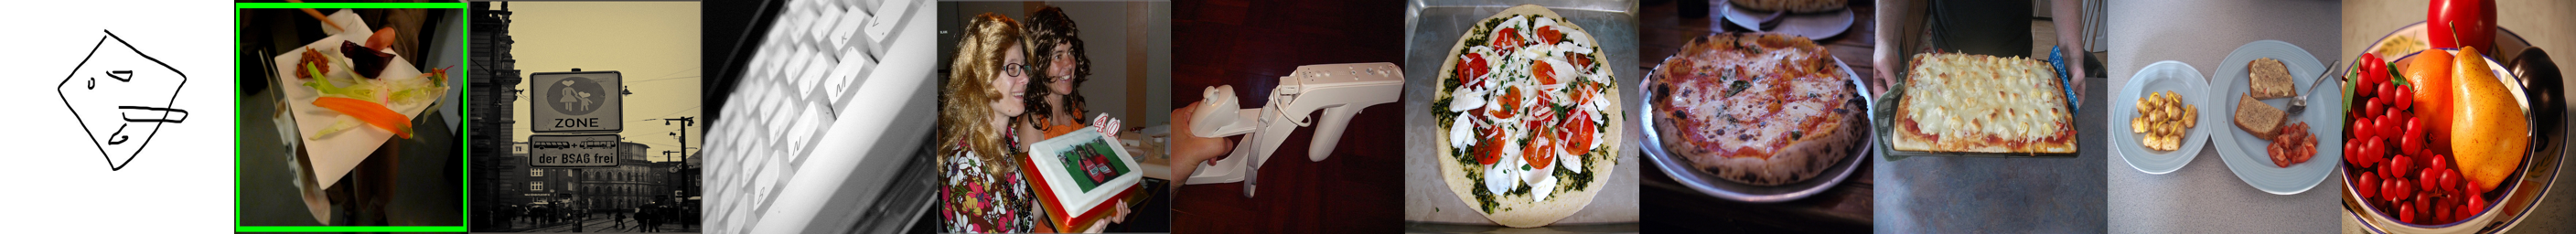

In [27]:
print('Caption: '+ caption)
display(get_concat_hn(im_list))